<a href="https://colab.research.google.com/github/mrkevinlin/MLmed/blob/master/keras_medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:
#**- Determine imputation to use**
#**- Determine measure of accuracy to use**
# **- Need to save state? DEFINITELY LOCK seeds for random splitting of data?**
# **- Document loss and errors in HDF5 format?**


# **- Visualize all data, remember data transformation**

# **Initialize everything**

In [0]:
!pip install --upgrade -q gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

from __future__ import print_function

import math
from google.colab import files
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 15
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format


gc = gspread.authorize(GoogleCredentials.get_application_default())

# Create a DataFrame of patient data

**Import CSV to populate a DataFrame**

In [0]:
# Open Google Sheet of patient data and get column titles
patient_dataframe = gc.open('patient_data').sheet1
column_names = patient_dataframe.row_values(1)

# Process Google Sheet into a pandas dataframe of all numeric values
patient_dataframe = pd.DataFrame.from_records(
    patient_dataframe.get_all_values(),
    columns=column_names)
patient_dataframe = patient_dataframe.iloc[1:]
patient_dataframe = patient_dataframe.apply(pd.to_numeric, errors='coerce')
patient_dataframe = patient_dataframe.replace('', np.nan)
patient_dataframe_original = patient_dataframe.copy()


# **View some stats on the data**

,year,entry_knowledge,entry_hads_a,entry_hads_d,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,entry_met,entry_chol,entry_trig,entry_hdl,entry_ldl,exit_knowledge,exit_hads_a,exit_hads_d,exit_weight,exit_waist,exit_BF,exit_BMI,exit_6mwt,exit_met,exit_chol,exit_trig,exit_hdl,exit_ldl
count,566.000,478.000,487.000,411.000,441.000,523.000,506.000,491.000,407.000,376.000,487.000,330.000,330.000,328.000,323.000,118.000,121.000,88.000,123.000,123.000,121.000,86.000,80.000,124.000,97.000,97.000,98.000,98.000
mean,2016.756,67.383,5.072,5.088,66.714,192.452,39.385,29.948,30.313,1083.535,2.551,159.458,135.733,47.384,88.077,73.924,3.479,2.682,187.728,38.219,27.508,29.002,1493.312,3.263,150.948,107.546,54.112,76.755
std,1.149,20.886,4.413,4.316,4.378,47.627,5.889,8.189,6.552,392.374,0.513,47.339,130.403,15.538,37.438,19.176,3.349,3.124,43.234,5.480,7.540,5.250,351.040,0.682,41.186,59.681,17.704,30.487
min,2015.000,0.000,0.000,0.000,54.250,90.600,24.000,9.000,17.000,200.000,1.100,51.000,33.000,11.000,7.000,15.000,0.000,0.000,121.600,27.250,15.900,19.310,300.000,1.400,69.000,43.000,31.000,24.000
25%,2016.000,54.000,1.000,2.000,63.750,159.150,35.500,23.705,25.120,900.000,2.300,127.250,76.000,36.000,61.000,62.000,0.000,0.000,156.800,34.750,21.800,24.150,1361.250,2.900,124.000,72.000,41.000,54.000
50%,2017.000,69.000,4.000,4.000,66.800,184.500,38.750,29.500,29.100,1100.000,2.600,152.000,107.000,45.000,84.000,77.000,3.000,2.000,182.400,37.500,26.810,28.300,1525.000,3.200,144.000,94.000,50.000,72.000
75%,2018.000,85.000,8.000,8.000,70.000,218.200,43.000,36.000,34.375,1276.000,2.900,184.750,153.000,56.000,106.500,92.000,6.000,4.000,209.500,41.250,32.200,33.147,1701.000,3.625,167.000,121.000,61.750,92.500
max,2019.000,100.000,21.000,21.000,79.000,399.200,64.500,50.000,62.300,5422.000,6.500,342.000,1549.000,100.000,245.000,100.000,13.000,14.000,299.600,64.000,43.820,40.720,2189.000,6.200,289.000,389.000,118.000,169.000



Number missing in each column:


year                 0
entry_knowledge     88
entry_hads_a        79
entry_hads_d       155
entry_height       125
entry_weight        43
entry_waist         60
                  ... 
exit_BMI           480
exit_6mwt          486
exit_met           442
exit_chol          469
exit_trig          469
exit_hdl           468
exit_ldl           468
Length: 28, dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


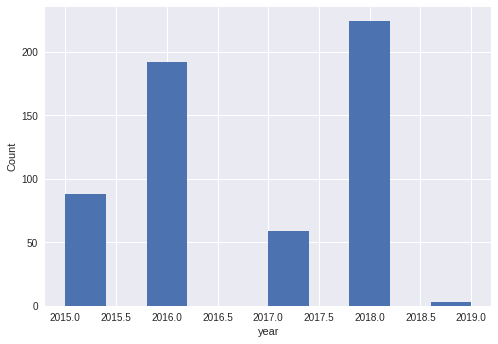

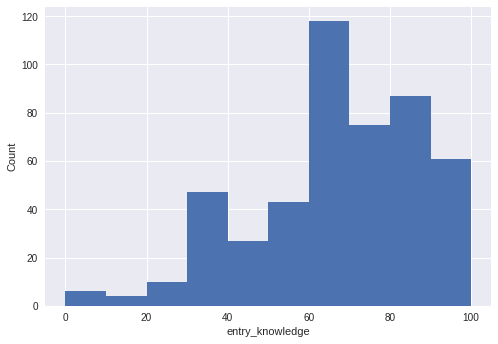

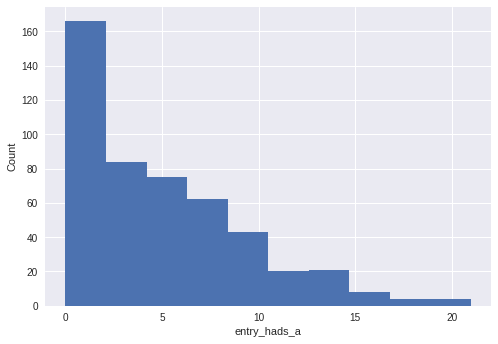

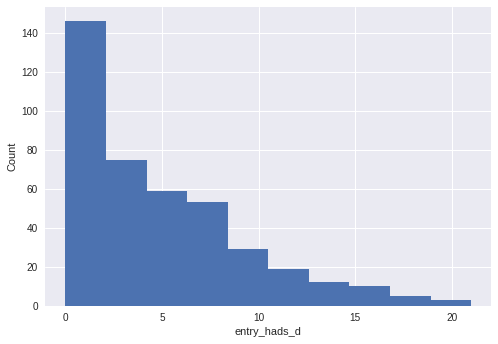

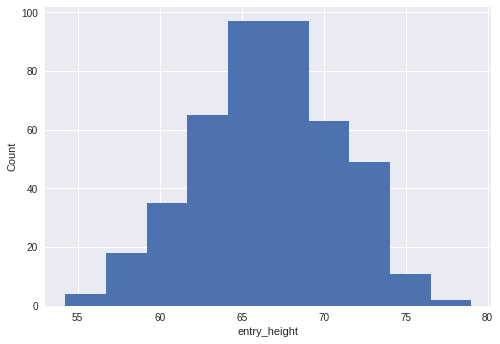

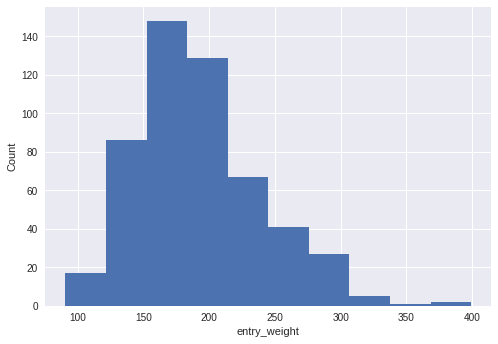

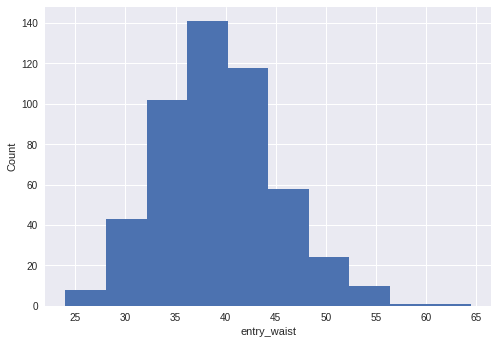

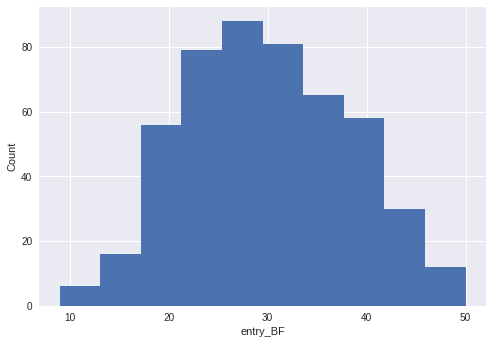

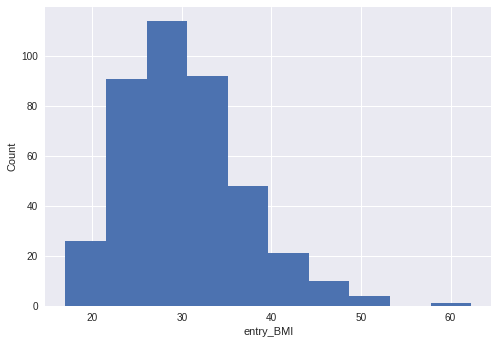

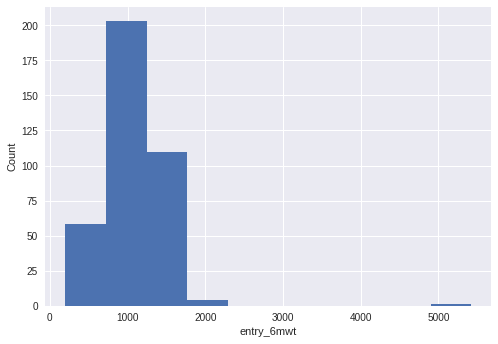

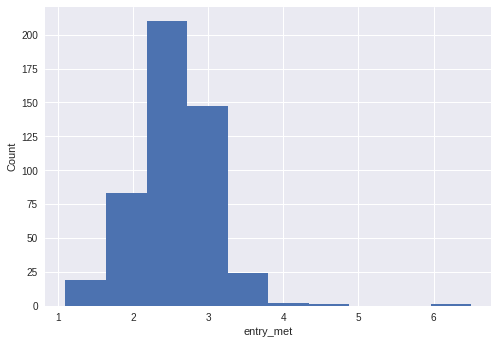

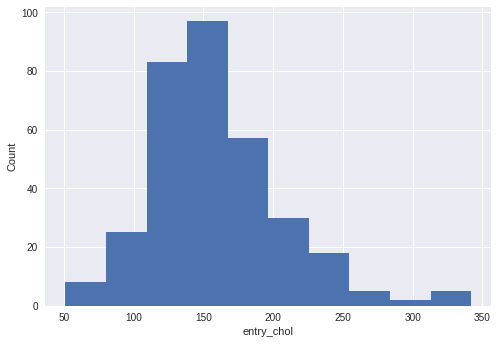

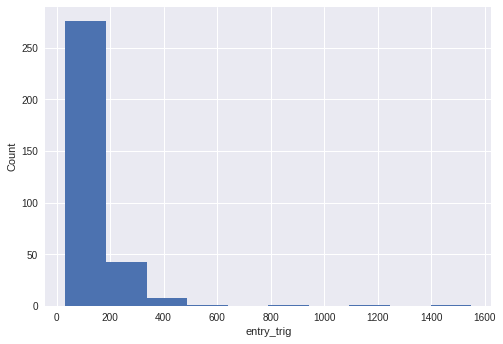

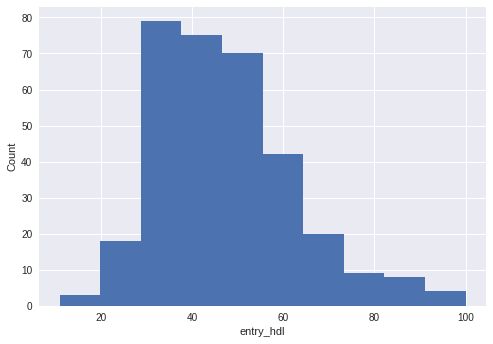

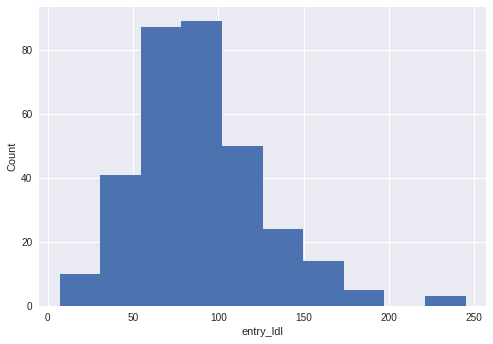

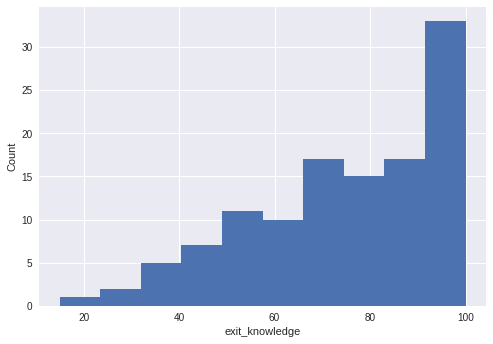

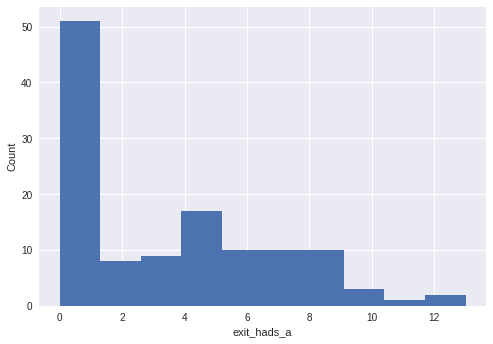

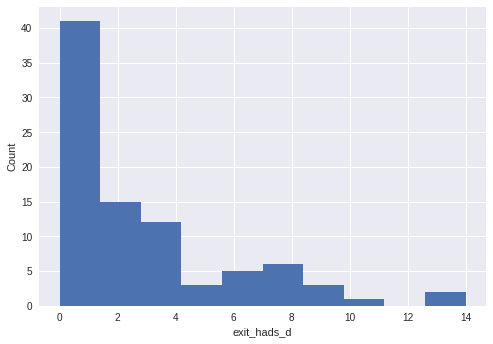

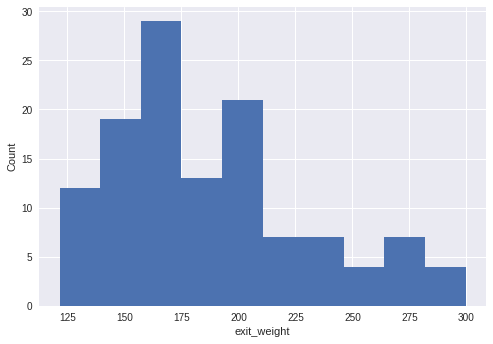

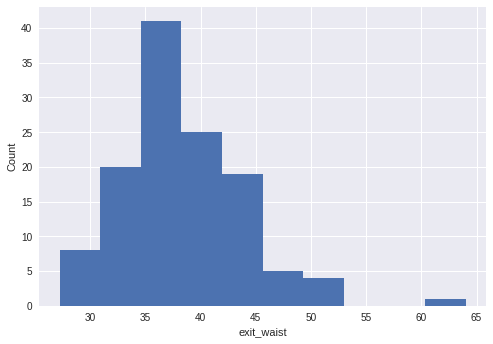

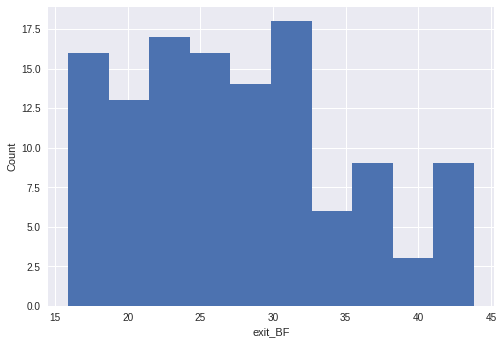

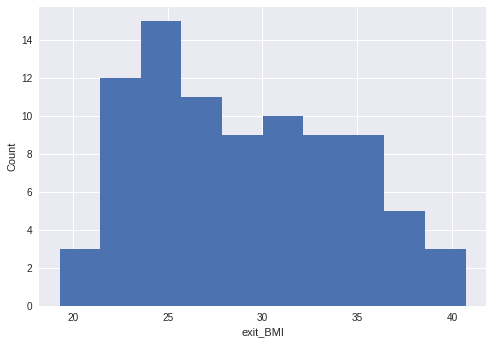

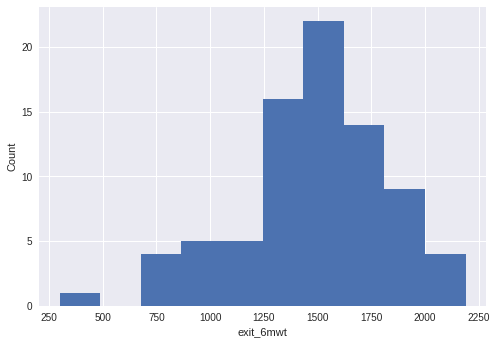

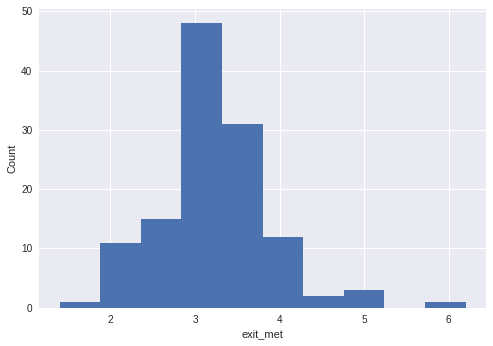

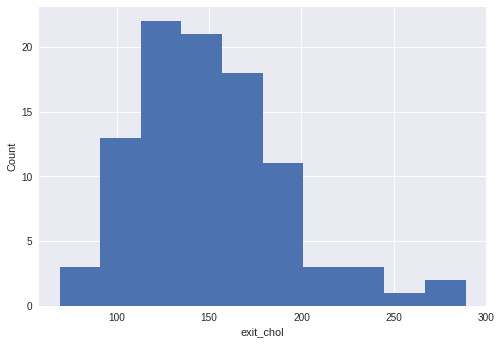

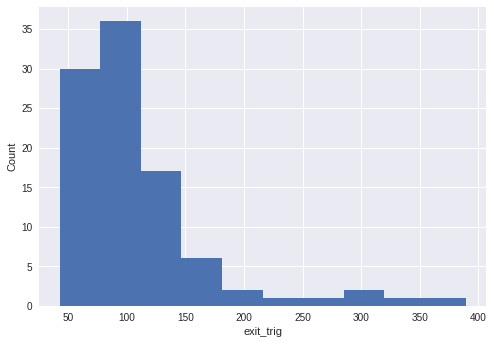

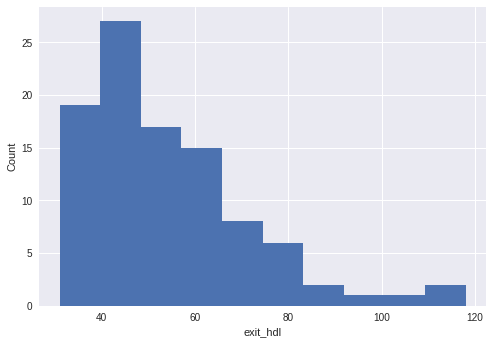

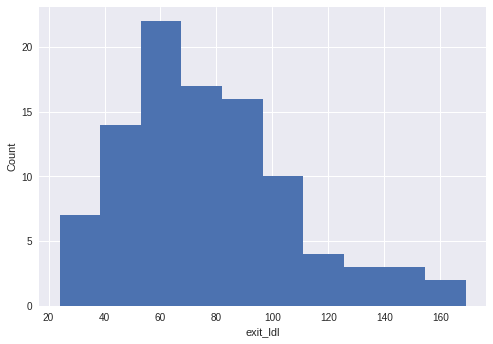

In [4]:
def view_stats(df):
  plt.close('all')
  display.display(df.describe())
  print("\nNumber missing in each column:")
  display.display(df.isna().sum())

  plt.close('all')
  for col in df.columns:
    plt.figure()
    plt.hist(df[col])
    plt.xlabel(col)
    plt.ylabel("Count")

view_stats(patient_dataframe)

# **Split into training and test sets**

In [0]:
# Randomly or make sure there are some exit_6wmt data points?

# **Create methods for cleaning up data**

In [22]:
# Close the matlib plots from view stats to reduce memory usage
plt.close('all')

def process_data(df):
  # Specify features and labels to work with
  target_label = 'delta_6mwt'
  #target_label = 'entry_met'
  numeric_selected_features = ['entry_knowledge', 'entry_height', 'entry_weight', 'entry_waist', 'entry_BF', 'entry_BMI', 'entry_met']
  optional_numeric_selected_features = ['entry_chol', 'entry_trig', 'entry_hdl', 'entry_ldl']
  categorical_selected_features = ['normal_a', 'borderline_a', 'anxiety', 'normal_d', 'borderline_d', 'depression']

  df = create_features(df, target_label)
  df = clean_up_by_target(df, target_label)
  df = remove_outliers(df, 'entry_trig', 1000)
  df = median_impute_missing_values(df) # Temporary  
  df[numeric_selected_features] = scale_features_z_score(df[numeric_selected_features].copy())
  
  # Split into used feature and label dataframes
  feature_df = df[numeric_selected_features+categorical_selected_features]
  target_df = df[target_label]
  
  return feature_df, target_df

# Create synthetic features
def create_features(df, target):
  df = create_target(df, target)
  df = calculate_bmi(df)
  df = create_hads_bins(df)
  return df

# Create target label of change in 6MWT results  
def create_target(df, target):
  df[target] = (df['exit_6mwt'] - df['entry_6mwt'])
  return df
  
# Create categorical bins of anxiety and depression scale
def create_hads_bins(df):
  hads_bins=[0,7,10,21]
  anxiety_df = pd.get_dummies(pd.cut(df['entry_hads_a'], bins=hads_bins, labels=['normal_a', 'borderline_a', 'anxiety']))
  depression_df = pd.get_dummies(pd.cut(df['entry_hads_d'], bins=hads_bins, labels=['normal_d', 'borderline_d', 'depression']))
  return df.join(anxiety_df).join(depression_df) 
  
# Recalculate and fill in BMI from height/weight
def calculate_bmi(df):
  df['calc_bmi'] = (702.95 * df['entry_weight']/(df['entry_height'] ** 2))
  return df

# Remove all rows with values missing in the specified columns
def clean_up_by_target(df, column):
  return df.dropna(subset=[column])

# Remove flagrant outliers by clipping
def remove_outliers(df, feature, maximum):
  df[feature] = df[feature].clip(lower=0, upper=maximum)
  return df

# Replace missing values with the median of the group (temporary measure)
def median_impute_missing_values(df):
  for col in df.columns:
    if df[col].isnull().values.any():
      df[col] = df[col].fillna(df[col].median())
  return df

# Normalize the values of features
def scale_features_z_score(df):
  for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()
  return df
  
feature_dataframe, target_dataframe = process_data(patient_dataframe)
display.display(feature_dataframe.describe())
#feature_dataframe.describe()

,entry_knowledge,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_met,normal_a,borderline_a,anxiety,normal_d,borderline_d,depression
count,80.000,80.000,80.000,80.000,80.000,80.000,80.000,80.000,80.000,80.000,80.000,80.000,80.000
mean,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.525,0.075,0.062,0.688,0.113,0.062
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.503,0.265,0.244,0.466,0.318,0.244
min,-3.345,-2.429,-1.505,-2.376,-2.035,-1.657,-2.689,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.587,-0.564,-0.795,-0.686,-0.652,-0.867,-0.591,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.194,-0.097,-0.174,-0.186,-0.029,-0.087,0.062,1.000,0.000,0.000,1.000,0.000,0.000
75%,0.642,0.733,0.762,0.778,0.631,0.794,0.549,1.000,0.000,0.000,1.000,0.000,0.000
max,1.251,2.700,2.495,2.289,2.084,2.581,2.354,1.000,1.000,1.000,1.000,1.000,1.000


Assess correlation of features to search for good features

In [0]:
# Determine correlations between features and target to find best features to use

#correlation_dataframe = edit_df.copy()
#correlation_dataframe["target"] = edit_df["delta_6mwt"]
#correlation_dataframe.corr()

# Process the patient DataFrame into training and test data

In [0]:
# Randomize and divide the data set into training and test sets
def divide_data(df, ratio):
  train_dataframe = df.sample(frac=ratio, random_state=0)
  test_dataframe = df.drop(train_dataframe.index)
  return train_dataframe, test_dataframe

# Create training and test sets for standard training
training_data, test_data = divide_data(edited_patient_dataframe, .8)
training_labels, test_labels = training_data.pop(target_feature[0]), test_data.pop(target_feature[0])
training_data, test_data = training_data[selected_features], test_data[selected_features]
#training_data, test_data = scale_features_z_score(training_data), scale_features_z_score(test_data)


# Create sets for cross validation
feature_data = edited_patient_dataframe.copy()
label_data = feature_data.pop(target_feature[0])
feature_data = feature_data[selected_features]
#feature_data = scale_features_z_score(feature_data)
# ^ Do not scale or prepare data outside of the cross-validation folds!


#Do things look ok?
print("Training summary:")
display.display(feature_data.describe())

print("Test summary:")
display.display(label_data.describe())


# **Set up Keras TensorFlow code**

**Build, train, and assess model with cross validation**

In [25]:
# Create a model
def build_model(train_df):
  model = keras.Sequential([
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu, input_shape=[len(train_df.columns)]),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mean_squared_logarithmic_error',
               optimizer=optimizer,
               metrics=['mean_squared_logarithmic_error', 'mae', 'mse'])
  return model

# Train and evaluate the model
def train_model(model, x_train, y_train, x_test, y_test, early_stop):
  if(early_stop):
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        verbose=1,
        callbacks = [early_stop_call],
        validation_data = (x_test, y_test)
    )
  else:
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        validation_data = (x_test, y_test)
    )
  return hist
  
# Stop training with no improvement
early_stop_call = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
end_fold_error = pd.DataFrame(columns=['loss', 'MSE', 'test_loss', 'test_MSE'])
  
# Create cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Loop through the k folds for cross validation
for i, (train_index, test_index) in enumerate(kf.split(patient_dataframe), 1):
  print("Training on fold " + str(i))
  
  #feature_train, feature_test = feature_data.iloc[train_index].copy(), feature_data.iloc[test_index].copy()
  #label_train, label_test = label_data.iloc[train_index], label_data.iloc[test_index]
  
  feature_train, label_train = process_data(patient_dataframe.iloc[train_index].copy())
  feature_test, label_test = process_data(patient_dataframe.iloc[test_index].copy())
  
  model = None
  model = build_model(feature_train)
  
  history = train_model(model, feature_train, label_train, feature_test, label_test, early_stop=True)
  mse_history = history.history['mean_squared_logarithmic_error']
  val_mse_history = history.history['val_mean_squared_logarithmic_error']
  end_fold_error = end_fold_error.append(
      pd.Series([history.history['loss'][-1],
                 mse_history[-1], 
                 history.history['val_loss'][-1],
                 val_mse_history[-1]], 
                index=end_fold_error.columns), ignore_index=True)
  print("Last training error: " + str(mse_history[-1]))
  print("Last validation error: " + str(val_mse_history[-1]))

#hist = pd.DataFrame(history.history)
#hist['epoch'] = history.epoch
#hist.tail()

Training on fold 1
Train on 56 samples, validate on 24 samples
Epoch 1/1000
56/56 [==============================] - 1s 16ms/sample - loss: 31.8094 - mean_squared_logarithmic_error: 29.9339 - mean_absolute_error: 412.2681 - mean_squared_error: 214216.2812 - val_loss: 28.8235 - val_mean_squared_logarithmic_error: 26.9647 - val_mean_absolute_error: 413.2410 - val_mean_squared_error: 240076.8750
Epoch 2/1000
56/56 [==============================] - 0s 291us/sample - loss: 28.0130 - mean_squared_logarithmic_error: 26.1554 - mean_absolute_error: 411.6779 - mean_squared_error: 213637.5938 - val_loss: 26.1091 - val_mean_squared_logarithmic_error: 24.2545 - val_mean_absolute_error: 412.6756 - val_mean_squared_error: 239568.7969
Epoch 3/1000
56/56 [==============================] - 0s 297us/sample - loss: 25.1551 - mean_squared_logarithmic_error: 23.3009 - mean_absolute_error: 411.0034 - mean_squared_error: 213065.1406 - val_loss: 24.1291 - val_mean_squared_logarithmic_error: 22.2765 - val_mean

In [26]:
end_fold_error

,loss,MSE,test_loss,test_MSE
0,1.427,0.789,1.415,0.778
1,1.316,0.862,0.848,0.392
2,2.083,1.117,1.720,0.758
3,0.946,0.334,5.189,4.577
4,1.547,0.973,1.139,0.565


**View error trends**

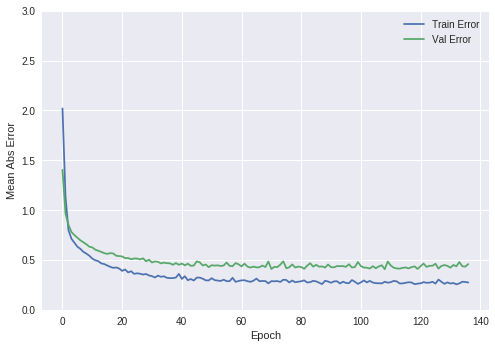

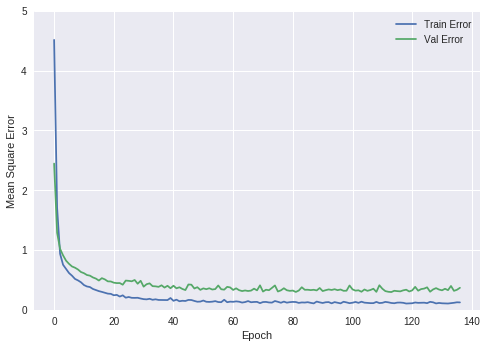

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,3])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

**Assess model performance on test data**

In [0]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

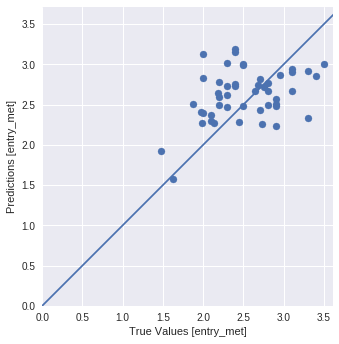

In [0]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ['+target_feature[0]+']')
plt.ylabel('Predictions ['+target_feature[0]+']')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

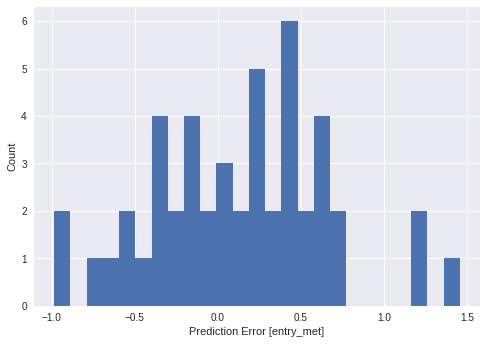

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error ['+target_feature[0]+']')
_ = plt.ylabel('Count')